In [2]:
import libforAutoMeasurements as lib1
from pylablib.devices import Ophir
import os
import sys
import ctypes as ct
import time
import numpy as np
import matplotlib.pyplot as plt
from ctypes import byref
from ctypes import *
from scipy.optimize import curve_fit



import time
import os
import sys
from ctypes import *

In [3]:

import ctypes
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qcodes_contrib_drivers
from qcodes_contrib_drivers.drivers.Thorlabs.K10CR1 import Thorlabs_K10CR1

In [4]:
import clr

clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\ThorLabs.MotionControl.KCube.SolenoidCLI.dll")
from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.KCube.SolenoidCLI import *
from System import Decimal  # necessary for real world units



# Определение функций

## Код для аттенюатора

In [5]:
def Kinesys_open(serial_num): # Open the device
    if lib.TLI_BuildDeviceList() == 0:
        lib.CC_Open(serial_num)
        lib.CC_StartPolling(serial_num, c_int(200))

        # Home the device
        lib.CC_Home(serial_num)
        time.sleep(1)

        # Set up the device to convert real units to device units
        STEPS_PER_REV = c_double(1919.64186)  # for the PRM1-Z8
        gbox_ratio = c_double(1.0)  # gearbox ratio
        pitch = c_double(1.0)

        # Apply these values to the device
        lib.CC_SetMotorParamsExt(serial_num, STEPS_PER_REV, gbox_ratio, pitch)

        # Get the device's current position in dev units
        lib.CC_RequestPosition(serial_num)
        time.sleep(0.2)
        dev_pos = c_int(lib.CC_GetPosition(serial_num))

        # Convert device units to real units
        real_pos = c_double()
        lib.CC_GetRealValueFromDeviceUnit(serial_num,
                                            dev_pos,
                                            byref(real_pos),
                                            0)

        print(f'Position after homing: {real_pos.value}')

In [6]:
def shutter_open(serial_no):


    DeviceManagerCLI.BuildDeviceList()

    


    device = KCubeSolenoid.CreateKCubeSolenoid(serial_no)
    device.Connect(serial_no)


    if not device.IsSettingsInitialized():
        device.WaitForSettingsInitialized(10000)  
        assert device.IsSettingsInitialized() is True

    # Start polling and enable
    device.StartPolling(250)  #250ms polling rate
    time.sleep(0.25)
    device.EnableDevice()
    time.sleep(0.5)  # Wait for device to enable


    
    device_info = device.GetDeviceInfo()
    print(device_info.Description)

    device.SetOperatingMode(SolenoidStatus.OperatingModes.Manual)
    print('shutter is ready')

In [7]:
def Open_Shutter(serial_num2):
   
    device.SetOperatingState(SolenoidStatus.OperatingStates.Active)
    print('shutter is opened')


In [8]:
def Close_Shutter(serial_num2):
    
    device.SetOperatingState(SolenoidStatus.OperatingStates.Inactive)
    print('shutter is closed')


In [21]:
class K10CR1_rotator:
    def __init__(self):
        print('start')
        self.apt = qcodes_contrib_drivers.drivers.Thorlabs.private.APT.Thorlabs_APT()
        self.inst = Thorlabs_K10CR1("K10CR1", 0, self.apt)
        print('apt succes')
        # Move to zero and recalibrate
        self.inst.move_home()
        self.max_velocity = None
        print('homing succes')
        # Read position
        #print("Position:", self.inst.position())
        self.current_pos = self.inst.position()
        self.current_max_angular_velocity = self.inst._get_velocity_max()
    def position_info(self, print_v: bool = True):
        self.current_pos = self.inst._get_position()
        if print_v:
            print("Position:", self.current_pos)

        return self.current_pos
    def rotation_to_angle(self, deg:float):
        try:
            if self.current_pos != deg:
                self.inst.position(deg)
                self.position_info()
        except:
            print('Rotator is currently at this position')
        
    def setup_velocity(self, max_velocity):
        self.max_velocity = max_velocity

    def jog(self, max_velocity: float = 10, direction: str = 'fwd'):
        if max_velocity <= float(30) or max_velocity != self.max_velocity:
            self.inst.velocity_max(max_velocity)
        if direction == '-' or direction == 'rev':
            self.inst.move_direction('rev')
        else: 
            if direction == '+' or direction == 'fwd':
                self.inst.move_direction('fwd')
            else:
                print('wrong directional parameter')
        print('jog finished')
        return self.position_info(print_v = False)
    
    def stop(self, print: bool = True):
        self.inst.stop()
        self.position_info(print_v = True)
        return self.current_pos
    
    # def movement_with_info(self, deg: float, max_velocity: float = 10):
    #     import time

      
    #     self.inst.position_async(deg)

  
    #     while self.current_pos < deg:
    #         self.position_info(print_v = True)
    #         time.sleep(0.25)
        
      
    #     # self.inst.stop()

    #     # print("Position:", self.inst.position())
    def close(self):
        self.inst.close()
        self.apt.apt_clean_up()

In [10]:
def rotation_to_angle(serial_num,x):
    new_pos_real = c_double(x)  # in real units
    
    new_pos_dev = c_int()      # in device units
    lib.CC_GetDeviceUnitFromRealValue(serial_num, new_pos_real, byref(new_pos_dev), 0)

    print(f'{new_pos_real.value} in Device Units: {new_pos_dev.value}')

    # Move to new position as an absolute move.
    lib.CC_SetMoveAbsolutePosition(serial_num, new_pos_dev)
    time.sleep(0.25)
    lib.CC_MoveAbsolute(serial_num)
    lib.CC_RequestPosition(serial_num)
    time.sleep(0.2)
    return new_pos_real

In [11]:
def small_rotation(serial_num,x):
    dev_pos = c_int(lib.CC_GetPosition(serial_num))
    real_pos = c_double()
    x_new = c_double(x)
    lib.CC_GetRealValueFromDeviceUnit(serial_num, dev_pos, byref(real_pos), 0) 
    new_pos_real = c_double(real_pos.value + x_new.value)  # in real units
    
    new_pos_dev = c_int()      # in device units
    lib.CC_GetDeviceUnitFromRealValue(serial_num, new_pos_real, byref(new_pos_dev), 0)

    print(f'{new_pos_real.value} in Device Units: {new_pos_dev.value}')

    # Move to new position as an absolute move.
    lib.CC_SetMoveAbsolutePosition(serial_num, new_pos_dev)
    time.sleep(0.25)
    lib.CC_MoveAbsolute(serial_num)
    lib.CC_RequestPosition(serial_num)
    time.sleep(0.2)
    return new_pos_real

In [12]:
def adjust_angle(serial_num,n,sleep):
    power = np.zeros(n)
    angle = np.zeros(n)
    agl = 180/n
    time_sleep = sleep/20

    power[0] = meter.get_power()
    angle[0] = 0
    for i in range(1,n):
        n1 = n
        avg_power = 0
        angle[i] = small_rotation(serial_num,agl).value
        time.sleep(sleep)
        for j in range(n):
            ppp = meter.get_power()
            print(ppp)
            if type(ppp) != float:
                ppp = 0
                n1 -=1
            avg_power += ppp
            
            time.sleep(time_sleep)
        power[i] = avg_power/n1
        
    A, B, C, D = calculate_sine_coefficients(angle, power)
    return A, B, C, D, power, angle

In [13]:
def power_angle(A, B, C, D, val):
    return (np.arcsin((val - D)/A) - C)/B *180/(np.pi)

### Подстройка углов вращения аттенюатора

In [14]:

def sine_function(x, A, B, C, D):
    """Sine function model."""
    return A * np.sin(B * x + C) + D

def calculate_sine_coefficients(angles_degrees, values):
    """
    Calculate coefficients of the sine function from angles and corresponding values.

    Parameters:
    - angles_degrees (np.ndarray): Array of angles in degrees.
    - values (np.ndarray): Corresponding values for the angles.

    Returns:
    - params (tuple): Coefficients (A, B, C, D) of the fitted sine function.
    """
    
    # Convert angles from degrees to radians
    angles_radians = np.radians(angles_degrees)

    # Initial guess for amplitude (A), frequency (B), phase (C), and offset (D)
    initial_guess = [max(values), 4.0, 0.0, 0.0]

    # Fit the sine function to the data
    params, _ = curve_fit(sine_function, angles_radians, values, p0=initial_guess)
    return params


In [15]:
def calculate_sine_values_and_angles(num_points):
    # Generate 15 evenly spaced angles from 0 to 360 degrees
    angles_degrees = np.linspace(0, 360, num_points)
    
    # Convert angles to radians for the sine function
    angles_radians = np.radians(angles_degrees)
    
    # Calculate the corresponding values using the given function
    values = 3 * np.sin(1.5 * angles_radians + 2 * np.pi) + 10
    
    return angles_degrees, values

In [16]:
def find_angle_for_sinusoid_value(A, f, phi, y_shift, y_target, degrees=True):
    """
    Находит угол, при котором синусоида принимает заданное значение.

    Параметры:
    A (float): Амплитуда синусоиды.
    f (float): Частота синусоиды.
    phi (float): Фаза синусоиды (в радианах).
    y_shift (float): Вертикальный сдвиг синусоиды.
    y_target (float): Заданное значение синусоиды.
    degrees (bool): Если True, возвращает угол в градусах, иначе в радианах.

    Возвращает:
    float: Угол, при котором синусоида принимает значение y_target.
    """
    # Нормализуем значение синусоиды
    normalized_value = (y_target - y_shift) / A

    # Проверяем, что значение находится в допустимом диапазоне [-1, 1]
    if not -1 <= normalized_value <= 1:
        raise ValueError("Заданное значение y_target находится вне диапазона синусоиды.")

    # Находим угол с использованием арксинуса
    angle = np.arcsin(normalized_value)

    # Учитываем фазу и частоту
    angle = (angle - phi) / f

    # Если нужно, преобразуем в градусы
    if degrees:
        angle = np.degrees(angle)

    return angle

### Рофлс для измерений

In [17]:
def time_dependent_on_one_point(t_acq, t, filename,rotation): 
    with open(str(filename) + '_'+str(t_acq) + 'ms'+ str(rotation) + 'rotation' '.txt', 'w') as file:
        phlib = ct.CDLL("phlib64.dll")
        start_time = time.time()
        t_end = start_time+t
        t_open = start_time + 7
        countrate = []
        Map = []
        Times = []
        Times_power = []
        power = []
        i = 0
        j = 1
        while time.time() < t_end:
                    if time.time() > t_open and rotation == 0 and j != 0:
                           Open_Shutter(serial_num2)
                           j = 0
                    s_time = time.time()
                    Picoharp.tryfunc(phlib.PH_GetCountRate(ct.c_int(Picoharp.dev[0]), ct.c_int(1), byref(Picoharp.countRate1)),\
            "GetCountRate")
                    countrate.append(Picoharp.countRate1.value)
                    Map.append(Picoharp.Measurement(t_acq))
                    e_time = time.time()                    
                    Times.append(e_time - start_time)

                    power.append(meter.get_power())
                    Times_power.append(time.time() - start_time)
                    line = f"Intensity: {Map[i]:.1f}, Countrate: {countrate[i]:.1f}, Power: {power[i]}, Start Time: {s_time}, End time: {e_time}\n"
                    file.write(line)
                    i+=1
       
    return Map, Times, countrate, power, Times_power

In [22]:
from pylablib.devices import Thorlabs
Thorlabs.list_kinesis_devices()

[('83847961', 'APT DC Motor Controller'),
 ('83846027', 'APT DC Motor Controller'),
 ('83846052', 'APT DC Motor Controller'),
 ('83847947', 'APT DC Motor Controller'),
 ('55173574', 'Kinesis K10CR1 Rotary Stage'),
 ('68000867', 'Solenoid Controller')]

In [19]:
aaa

NameError: name 'aaa' is not defined

In [23]:
K10CR1_device = K10CR1_rotator()

start


: 

In [ ]:
K10CR1_dev.close()

In [ ]:
import time

def rotate_until_max_power(meter, rotator, direction='fwd', poll_interval=0.1, max_wait=60):
    """
    Запускает вращение rotator в указанном направлении ('fwd' или 'rvs'),
    отслеживает показания мощности через meter.get_power(),
    при достижении максимума останавливает вращатель и открывает shutter.

    Параметры:
    - meter: объект мощиметра с методом get_power()
    - rotator: объект вращателя с методами jog(direction) и stop()
    - shutter: объект затвора с методом open()
    - direction: направление вращения ('fwd' или 'rvs')
    - poll_interval: время между измерениями мощности (сек)
    - max_wait: максимальное время ожидания в секундах (чтобы не зациклиться)
    """
    
    rotator.jog(direction = direction)  # Начинаем вращение
    print(f"Rotator started moving {direction}")
    tol = 1e-6 # 0.1 mW + OD20
    # min_power = float('inf')
    # min_power_time = time.time()
    # stable_count = 0  # счётчик стабильных максимальных значений
    # min_power_value = None

    # start_time = time.time()

    # while True:
    #     if time.time() - start_time > max_wait:
    #         print("Timeout reached, stopping rotation.")
    #         break

    #     power = meter.get_power()
    #     if power is None or type(power) != float:
    #         print("Warning: meter returned None power value. Retrying...")
    #         time.sleep(poll_interval)
    #         continue

    #     # Обновляем максимум если нашли большее значение мощности
    #     if power < min_power and np.abs(power - min_power) > np.abs(tol*min_power)  :
    #         min_power = power
    #         min_power_time = time.time()
    #         stable_count = 0
    #         min_power_value = power
    #     if np.abs(power - min_power) < tol*min_power:

    #         stable_count += 1
    #         if stable_count >= 2:  
    #             print(f"Maximum power detected: {min_power_value:.4f} W")
    #             break

    #     time.sleep(poll_interval)
    power = []
    power_prev = meter.get_power()
    flag = 0
    while True:
        power_current = meter.get_power()
        power.append(power_current)
        try:
            if power_current - power_prev >= tol and power_current < 5e-6:
                # power_direction = -1
                Open_Shutter()
                break
            # else: power_direction = 1
            # if power > power1 and power1 > power2 and np.abs(power1-power2) < tol:
            #     rotator.stop()
        except:
            continue
        power_prev = power_current

    plt.plot(power)
    # rotator.stop()
    # print("Rotator stopped.")
    
    # Open_Shutter()
    # print("Shutter opened.")
    # Close_Shutter()
    # return min_power_value

In [ ]:
K10CR1_device.stop()

TypeError: 'bool' object is not callable

jog finished
Rotator started moving fwd


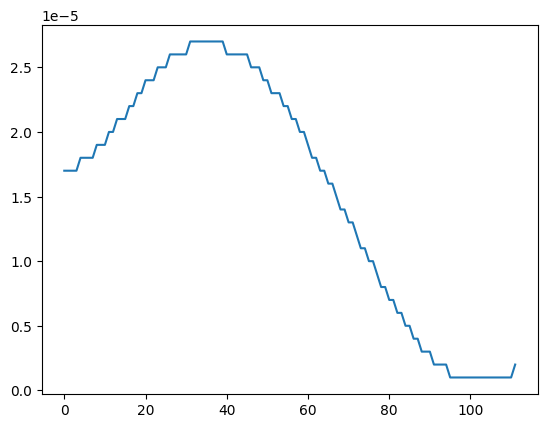

In [ ]:
rotate_until_max_power(meter, K10CR1_device, 'fwd')

In [ ]:
def Time_Dependent_Mes(i,t_acq, t_end,velocity, direction, rotator = K10CR1_device):
    rotator.setup_velocity(max_velocity=velocity)
    rotate_until_max_power(meter, rotator, direction)
    
    # rotator.jog(direction=direction)
    Map, Times, countrate, power, Times_power = time_dependent_on_one_point(t_acq, t_end, i, velocity)
    rotator.stop()
    Close_Shutter(serial_num2)
    fig, axs = plt.subplots(5)
    ax = axs[0]
    ax.plot(Times,Map, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('integral intensity (counts)')

    ax = axs[1]
    ax.plot(Times,countrate, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Countrate (counts/sec)')

    ax = axs[2]
    ax.plot(Times_power,power, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Power (W)')

    ax = axs[3]
    time1 = np.array(Times)
    power = np.array(power)
    ax.plot(power, countrate, '-o')
    ax.set_xlabel('Excitation power (W)')
    ax.set_ylabel('SHG power (W)')

    ax = axs[4]
    power1 = np.interp(time1 - 0.14, time1, power)
    
    ax.plot(power1, countrate, '-o')
    ax.set_xlabel('Excitation power (W)')
    ax.set_ylabel('SHG power (W)')
    


    plt.savefig(i+ str(max(power)) + 'mW' + str(t_acq) + 'ms' + str(t_end) + 's' + '.png')
    plt.tight_layout()
    plt.show()
    return Map, Times, countrate, power, Times_power, power1

In [ ]:
def Time_Dependent_Mes_no_rot(i,t_acq, t_end):
    
    Map, Times, countrate, power, Times_power = time_dependent_on_one_point(t_acq, t_end, i, 0)
    Close_Shutter(serial_num2)
    fig, axs = plt.subplots(5)
    ax = axs[0]
    ax.plot(Times,Map, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('integral intensity (counts)')

    ax = axs[1]
    ax.plot(Times,countrate, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Countrate (counts/sec)')

    ax = axs[2]
    ax.plot(Times_power,power, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Power (W)')

    ax = axs[3]
    time1 = np.array(Times)
    power = np.array(power)
    ax.plot(power, countrate, '-o')
    ax.set_xlabel('Excitation power (W)')
    ax.set_ylabel('SHG power (W)')

    ax = axs[4]
    power = np.interp(time1 - 0.14, time1, power)
    
    ax.plot(power, countrate, '-o')
    ax.set_xlabel('Excitation power (W)')
    ax.set_ylabel('SHG power (W)')

    plt.savefig(i+ str(max(power)) + 'mW' + str(t_acq) + 'ms' + str(t_end) + 's' + '.png')
    plt.tight_layout()
    plt.show()
    return Map, Times, countrate, power, Times_power

In [ ]:
def time_dependent_on_one_point_with_power_rotation(t_acq, t, filename, needed_powers, A, B, C, D): 
    with open(str(filename) + str(t_acq) + 'ms'+ '.txt', 'w') as file:
        phlib = ct.CDLL("phlib64.dll")
        start_time = time.time()
        t_end = start_time+t
        countrate = []
        Map = []
        Times = []
        Times_power = []
        power = []
        i = 0
        j = 0
        x = 0
        while time.time() < t_end:
                    angle_in_degrees = power_angle(-A,B,C,D,needed_powers[x])
                    rotation_to_angle(serial_num,angle_in_degrees)
                    time.sleep(1.6)
                    s_time = time.time()
                    Picoharp.tryfunc(phlib.PH_GetCountRate(ct.c_int(Picoharp.dev[0]), ct.c_int(1), byref(Picoharp.countRate1)),\
            "GetCountRate")
                    countrate.append(Picoharp.countRate1.value)
                    Map.append(Picoharp.Measurement(t_acq))
                    e_time = time.time()                    
                    Times.append(e_time - start_time)
                    power.append(meter.get_power())
                    power_time = time.time()
                    Times_power.append(power_time - start_time)
                    line = f"Intensity: {Map[i]:.1f}, Countrate: {countrate[i]:.1f}, Power: {power[i]}, Start Time: {s_time}, End_time: {e_time}\n"
                    file.write(line)
                    if x <= len(needed_powers) - 1 and j == 0:
                           x+=1
                    if x == len(needed_powers) and j == 0:
                            j = 1
                    if x > 0 and j == 1:
                          x -= 1
                    if x == 0 and j == 1:
                        j = 0
                    i += 1
    return Map, Times, countrate, power, Times_power

In [ ]:
import winsound

In [ ]:
def sound_notification(frequency=1000, duration=1000):
    """
    Play a sound notification using winsound.

    Parameters:
    - frequency (int): Frequency of the sound in Hertz (default is 1000 Hz).
    - duration (int): Duration of the sound in milliseconds (default is 1000 ms).
    """
    winsound.Beep(frequency, duration)

In [ ]:
sound_notification()

In [ ]:
def LineAfterLineMes(Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angles,tacq):
    #Map = np.zeros((iter_x,iter_y,needed_powers.shape[0]))
    Map = np.zeros((iter_x,iter_y))
    x_c = Pjesa.pesa1.cord
    y_c = Pjesa.pesa2.cord
    print(x_c,y_c)
    print(1)
    #if (x_c >= 0) and (x_c + x_movement < 50) and (y_c >= 0) and (y_c + y_movement < 50):
    if (x_c - x_movement > 0) and (x_c + x_movement < 50) and (y_c - y_movement > 0) and (y_c + y_movement < 50):
        #x = np.linspace(x_c, x_c + x_movement, iter_x)
        #y = np.linspace(y_c, y_c + y_movement, iter_y)
        x = np.linspace(x_c - x_movement, x_c + x_movement, iter_x)
        y = np.linspace(y_c - y_movement, y_c + y_movement, iter_y)
        print(x)
        print(y)
        for ix in range(x.shape[0]):
            if ix % 2 == 1:
                Ystart = y.shape[0]-1
                Yend = -1
                step = -1
            else:
                Ystart = 0
                Yend = y.shape[0]
                step = 1        
            for iy in range(Ystart, Yend, step):
                Pjesa.pesa1.move(x[ix])
                Pjesa.pesa2.move(y[iy])
                #for i in range(needed_powers.shape[0]):
                    #A, B, C, D = calculate_sine_coefficients(angles, power)
                    #angle_in_degrees = power_angle(-A,B,C,D,needed_powers[i])
                    #rotation_to_angle(serial_num,angle_in_degrees)
                    #time.sleep(1)
                    #Map[ix][iy][i] = Picoharp.Measurement(tacq)
                Map[ix][iy] = Picoharp.Measurement(tacq)
                

        Pjesa.pesa1.move(x_c)
        Pjesa.pesa2.move(y_c)
        lib1.write_2d_array_to_file(x, y, needed_powers, Map,'КартаИзмерения')
        sound_notification(2000,1000)
    return Map

In [ ]:
def LineAfterLineMesToFile(filename, Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angles,tacq):
    #Map = np.zeros((iter_x,iter_y,needed_powers.shape[0]))
    with open(filename, 'w') as file:
        Map = np.zeros((iter_x,iter_y))
        x_c = Pjesa.pesa1.cord
        y_c = Pjesa.pesa2.cord
        print(x_c,y_c)
        print(1)
        #if (x_c >= 0) and (x_c + x_movement < 50) and (y_c >= 0) and (y_c + y_movement < 50):
        if (x_c - x_movement > 0) and (x_c + x_movement < 50) and (y_c - y_movement > 0) and (y_c + y_movement < 50):
            #x = np.linspace(x_c, x_c + x_movement, iter_x)
            #y = np.linspace(y_c, y_c + y_movement, iter_y)
            x = np.linspace(x_c - x_movement, x_c + x_movement, iter_x)
            y = np.linspace(y_c - y_movement, y_c + y_movement, iter_y)
            print(x)
            print(y)
            for ix in range(x.shape[0]):
                if ix % 2 == 1:
                    Ystart = y.shape[0]-1
                    Yend = -1
                    step = -1
                else:
                    Ystart = 0
                    Yend = y.shape[0]
                    step = 1        
                for iy in range(Ystart, Yend, step):
                    Pjesa.pesa1.move(x[ix])
                    Pjesa.pesa2.move(y[iy])
                    #for i in range(needed_powers.shape[0]):
                        #A, B, C, D = calculate_sine_coefficients(angles, power)
                        #angle_in_degrees = power_angle(-A,B,C,D,needed_powers[i])
                        #rotation_to_angle(serial_num,angle_in_degrees)
                        #time.sleep(1)
                        #Map[ix][iy][i] = Picoharp.Measurement(tacq)
                    start_time = time.perf_counter()
                    Map[ix][iy] = Picoharp.Measurement(tacq)
                    end_time = time.perf_counter()
                    elapsed_time = end_time - start_time
                    line = f"Coordinates: {x[ix]:.1f}, {y[iy]:.1f}, Intensity: {Map[ix][iy]:.1f}, Power: {power:.1f}, Start Time: {start_time}, End_time {end_time}\n"
                    file.write(line)

            Pjesa.pesa1.move(x_c)
            Pjesa.pesa2.move(y_c)
            #lib.write_2d_array_to_file(x, y, needed_powers, Map,'КартаИзмерения')
            sound_notification(2000,1000)
    return Map


In [ ]:
def plot_2d_array_as_colormap(data, cmap='viridis', colorbar=True, title='2D Color Map'):
    """
    Plots a 2D array as a color map.

    Parameters:
    - data (np.ndarray): 2D array to be plotted.
    - cmap (str): Colormap to use for visualization.
    - colorbar (bool): Whether to display a colorbar.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    
    # Use imshow to display the 2D array as an image
    cax = plt.imshow(data, cmap=cmap, aspect='auto')
    
    # Optionally add a colorbar
    if colorbar:
        plt.colorbar(cax)
    
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.show()

In [ ]:
def LineAfterLineMeswithPower(Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angles,tacq):
    Map = np.zeros((iter_x,iter_y,needed_powers.shape[0]))
    #Map = np.zeros((iter_x,iter_y))
    x_c = Pjesa.pesa1.cord
    y_c = Pjesa.pesa2.cord

    #if (x_c >= 0) and (x_c + x_movement < 50) and (y_c >= 0) and (y_c + y_movement < 50):
    if (x_c - x_movement > 0) and (x_c + x_movement < 50) and (y_c - y_movement > 0) and (y_c + y_movement < 50):
        #x = np.linspace(x_c, x_c + x_movement, iter_x)
        #y = np.linspace(y_c, y_c + y_movement, iter_y)
        x = np.linspace(x_c - x_movement, x_c + x_movement, iter_x)
        y = np.linspace(y_c - y_movement, y_c + y_movement, iter_y)
        print(x)
        print(y)
        for ix in range(x.shape[0]):
            if ix % 2 == 1:
                Ystart = y.shape[0]-1
                Yend = -1
                step = -1
            else:
                Ystart = 0
                Yend = y.shape[0]
                step = 1        
            for iy in range(Ystart, Yend, step):
                Pjesa.pesa1.move(x[ix])
                Pjesa.pesa2.move(y[iy])
                for i in range(needed_powers.shape[0]):
                    A, B, C, D = calculate_sine_coefficients(angles, power)
                    angle_in_degrees = power_angle(-A,B,C,D,needed_powers[i])
                    rotation_to_angle(serial_num,angle_in_degrees)
                    time.sleep(2)
                    count = Picoharp.Measurement(tacq)
                    Map[ix][iy][i] = count
                    

        Pjesa.pesa1.move(x_c)
        Pjesa.pesa2.move(y_c)
        lib.write_2d_array_to_file(x, y, needed_powers, Map,'КартаИзмерения')
        sound_notification(2000,1000)
    return Map

In [ ]:
def Time_Dependent_Mes_rot_power(i,t_acq, t_end, needed_powers, A, B, C, D):
    
    Map, Times, countrate, power, Times_power = time_dependent_on_one_point_with_power_rotation(t_acq, t_end, i, needed_powers, A, B, C, D)
    fig, axs = plt.subplots(4)
    ax = axs[0]
    ax.plot(Times,Map, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('integral intensity (counts)')

    ax = axs[1]
    ax.plot(Times,countrate, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Countrate (counts/sec)')

    ax = axs[2]
    ax.plot(Times_power,power, '-o')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Power (W)')

    ax = axs[3]
    power = np.array(power)
    ax.plot(max(power) - power, countrate, '-o')
    ax.set_xlabel('Excitation power (W)')
    ax.set_ylabel('SHG power (W)')

    plt.savefig(i+ str(max(power)) + 'mW' + str(t_acq) + 'ms' + str(t_end) + 's' + '.png')
    plt.tight_layout()
    plt.show()
    return Map, Times, countrate, power, Times_power

## Код для нахождения частиц

In [ ]:
def create_circular_gradient(size,x,max_intencity):
    """
    Создает квадратный массив с круговым градиентом, 
    где значения увеличиваются от краев к центру
    
    Параметры:
    size - размер квадратного массива (size x size)
    """
    # Создаем координатную сетку
    x = np.linspace(-1, 1, x.shape[0])
    y = np.linspace(-1, 1, x.shape[0])
    X, Y = np.meshgrid(x, y)
    
    # Вычисляем расстояние от центра для каждой точки
    distance = np.sqrt(X**2 + Y**2)
    
    # Нормализуем расстояния (1 на краях, 0 в центре)
    normalized = max_intencity * distance / np.max(distance)
    
    # Инвертируем, чтобы значения увеличивались к центру
    gradient = max_intencity - normalized + x
    
    
    return gradient

# Подключаем устройства

In [ ]:
tacq = 100

In [ ]:
Picoharp = lib1.PicoHarpController(tacq)
Picoharp.initialize_device


Library version is 3.0

Searching for PicoHarp devices...
Devidx     Status
  0        S/N 1030137
  1        no device
  2        no device
  3        no device
  4        no device
  5        no device
  6        no device
  7        no device
Using device #0

Initializing the device...
Found Model PicoHarp 300 Part no 930004 Version 2.0

Calibrating...
Resolution=4.000000 Countrate0=1000000/s Countrate1=26590/s


<bound method PicoHarpController.initialize_device of <libforAutoMeasurements.PicoHarpController object at 0x000001B6D0FDA110>>

In [ ]:
meter = Ophir.VegaPowerMeter(('COM6',115200))

In [ ]:
meter.get_power()

1.5e-05

In [ ]:
serial_num2 =  "68000867"
serial_num3 = "55173574"

In [ ]:
if sys.version_info < (3, 8):
    os.chdir(r"C:\\Program Files\\Thorlabs\\Kinesis")
else:
    os.add_dll_directory(r"C:\\Program Files\\Thorlabs\\Kinesis")

lib: CDLL = cdll.LoadLibrary("Thorlabs.MotionControl.KCube.DCServo.dll")

# Uncomment this line if you are using simulations
#lib.TLI_InitializeSimulations()

# Set constants
#serial_num = c_char_p(b"27005137")
serial_num = c_char_p(b"27254803")

In [ ]:
DeviceManagerCLI.BuildDeviceList()




device = KCubeSolenoid.CreateKCubeSolenoid(serial_num2)
device.Connect(serial_num2)


if not device.IsSettingsInitialized():
    device.WaitForSettingsInitialized(10000)  
    assert device.IsSettingsInitialized() is True

# Start polling and enable
device.StartPolling(250)  #250ms polling rate
time.sleep(0.25)
device.EnableDevice()
time.sleep(0.5)  # Wait for device to enable



device_info = device.GetDeviceInfo()
print(device_info.Description)

device.SetOperatingMode(SolenoidStatus.OperatingModes.Manual)
print('shutter is ready')

KSC101 Solenoid Controller      v3.1          1
shutter is ready


In [ ]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
Kinesys_open(serial_num)

Position after homing: 99.9999


In [ ]:
aaa

NameError: name 'aaa' is not defined

# Calibration of the rotator

In [ ]:
rotation_to_angle(serial_num,0)

0.0 in Device Units: 0


c_double(0.0)

In [ ]:
Close_Shutter(serial_num2)

shutter is closed


In [ ]:
Open_Shutter(serial_num2)

shutter is opened


In [ ]:
rotation_to_angle(serial_num,0)

0.0 in Device Units: 0


c_double(0.0)

In [ ]:
A,B,C,D, adj_powers, adj_angles = adjust_angle(serial_num,20,1)

108.9999 in Device Units: 209241
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05
1.9e-05


KeyboardInterrupt: 

In [ ]:
A1, B1, C1, D1 = calculate_sine_coefficients(adj_angles, adj_powers)

In [ ]:
print(A-A1, B-B1, C- C1, D - D1)

0.0 0.0 0.0 0.0


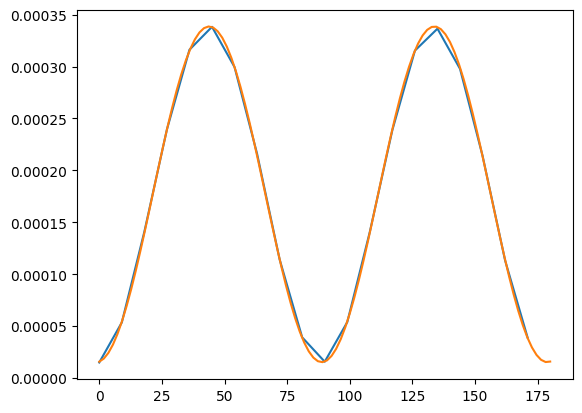

In [ ]:
plt.plot(adj_angles,adj_powers)
plt.plot(np.linspace(0,180,100),A*np.sin(B*np.pi/180*np.linspace(0,180,100)+C)+D)

### Powers

In [ ]:
needed_powers = np.linspace(min(adj_powers)+2e-4,max(adj_powers)-2e-5,10)

In [ ]:
print(max(adj_powers))

0.00019533999999999996


In [ ]:
print(needed_powers)

[0.000215   0.00022648 0.00023796 0.00024943 0.00026091 0.00027239
 0.00028387 0.00029534 0.00030682 0.0003183 ]


In [ ]:
needed_powers[len(needed_powers)-1]

0.0007732500000000002

In [ ]:
from pylablib.devices import Thorlabs
Thorlabs.list_kinesis_devices()
rotator = Thorlabs.KinesisMotor("27254803")
rotator.get_scale()
rotator.get_velocity_parameters()




TVelocityParams(min_velocity=0.0, acceleration=19252.18384712934, max_velocity=19196.122884750366)

In [ ]:
rotator.move_to(5*1e4)

In [ ]:
meter.get_power()

0.0

In [ ]:
import ctypes as ct

In [ ]:
angle_in_degrees = power_angle(-A,B,C,D,needed_powers[0])
rotation_to_angle(serial_num,angle_in_degrees)

33.04425550055099 in Device Units: 63433


c_double(33.04425550055099)

In [ ]:
rotation_to_angle(serial_num,10000)

10000.0 in Device Units: 0


c_double(10000.0)

In [ ]:
Open_Shutter(serial_num2)

shutter is opened


In [ ]:
Close_Shutter(serial_num2)

shutter is closed


17.9392967110847 in Device Units: 34437
Countrate0=999990/s Countrate1=617730/s

Measuring for 100 milliseconds...
16.883094282082737 in Device Units: 32409
Countrate0=999990/s Countrate1=15980/s

Measuring for 100 milliseconds...
15.801143335992919 in Device Units: 30333
Countrate0=1000000/s Countrate1=155390/s

Measuring for 100 milliseconds...
14.684720412607064 in Device Units: 28189
Countrate0=1000000/s Countrate1=1407860/s

Measuring for 100 milliseconds...
13.522700620652689 in Device Units: 25959
Countrate0=1000000/s Countrate1=761400/s

Measuring for 100 milliseconds...
12.300137705441864 in Device Units: 23612
Countrate0=1000000/s Countrate1=16480/s

Measuring for 100 milliseconds...
10.995686826686317 in Device Units: 21108
Countrate0=1000000/s Countrate1=98120/s

Measuring for 100 milliseconds...
9.576411786881312 in Device Units: 18383
Countrate0=1000000/s Countrate1=1218680/s

Measuring for 100 milliseconds...
7.985698542577372 in Device Units: 15330
Countrate0=1000000/s 

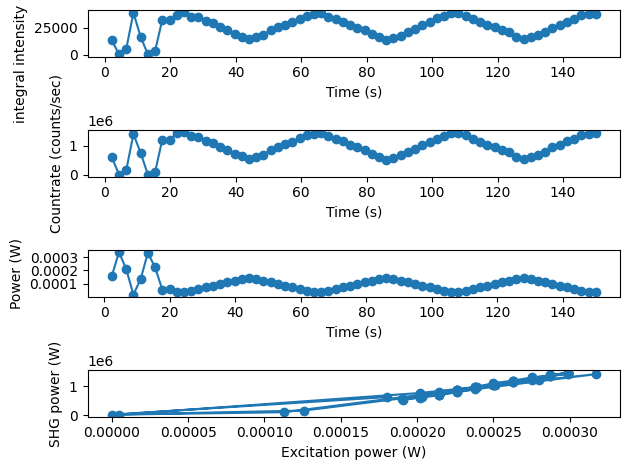

In [ ]:
i = 'AuSiTesting'
t_end = 150
t_acq = 100
Map, Times, counts, power, Times_power = Time_Dependent_Mes_rot_power(i,t_acq, t_end, needed_powers, A, B, C, D)

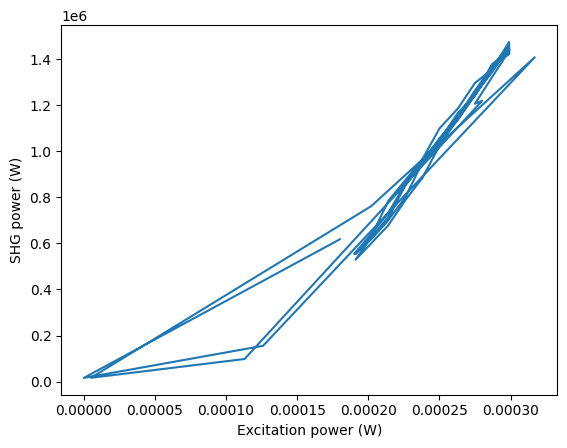

In [ ]:

power = np.array(power)
plt.plot(max(power) - power, counts, '-')
plt.xlabel('Excitation power (W)')
plt.ylabel('SHG power (W)')

plt.show()

In [ ]:
rotator.stop()

# rotator code

In [ ]:
import ctypes as ct

In [ ]:
j = 0

In [ ]:

import datetime
 
current_time = datetime.datetime.now()
x = str(current_time.year) +'_'+ str(current_time.month)+'_'+ str(current_time.day) +'_'+ str(current_time.hour) +'_'+ str(current_time.minute)+'_'+ str(current_time.second)
print(x)

2025_10_5_14_57_1


In [ ]:
j = 0

In [ ]:
Open_Shutter(serial_num2)

shutter is opened


In [ ]:
Close_Shutter(serial_num2)

shutter is closed


In [ ]:
meter.get_power()

0.001749

In [ ]:
rotator.stop()

# RotationSpeedMes

In [ ]:
Picoharp = lib1.PicoHarpController(tacq)
Picoharp.initialize_device



Library version is 3.0

Searching for PicoHarp devices...
Devidx     Status
  0        S/N 1030137
  1        no device
  2        no device
  3        no device
  4        no device
  5        no device
  6        no device
  7        no device
Using device #0

Initializing the device...
Found Model PicoHarp 300 Part no 930004 Version 2.0

Calibrating...
Resolution=4.000000 Countrate0=999990/s Countrate1=24920/s


<bound method PicoHarpController.initialize_device of <libforAutoMeasurements.PicoHarpController object at 0x000001B70C489590>>

In [ ]:
j = 0

shutter is opened
Countrate0=1000000/s Countrate1=15940/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=17500/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=20580/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=20630/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=20380/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=19420/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=19920/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=19630/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=19120/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=19700/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=19490/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=19390/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=19110/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countr

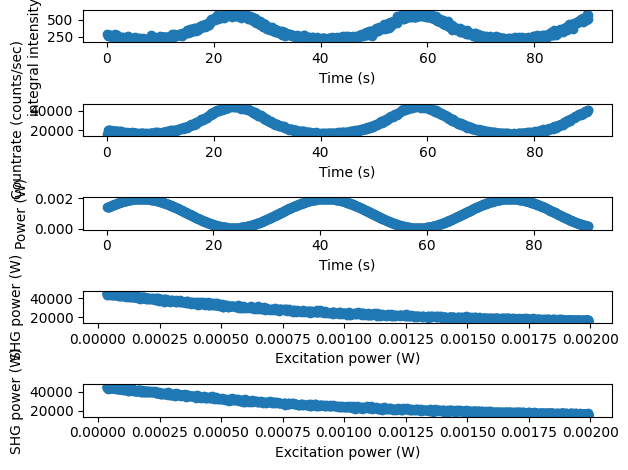

In [ ]:
j+=1
power_modification = 'od2_power_meter_nothing_spad'
rotation_velocity = '5000'
sample = ['Ga_As','Au_Si', 'TiO2_Au','Si_Au','Si','TiO2_new']
t_end = 90
t_acq = 50
current_time = datetime.datetime.now()
x = str(current_time.year) +'_'+ str(current_time.month)+'_'+ str(current_time.day) +'_'+ str(current_time.hour) +'_'+ str(current_time.minute)+'_'+ str(current_time.second)
i = sample[4]+power_modification + 'rotation_velocity_' + rotation_velocity + '_' +  x + str(t_end) + 's'


Map, Times, counts, power, Times_power, power1 = Time_Dependent_Mes(i, t_acq, t_end, int(rotation_velocity))


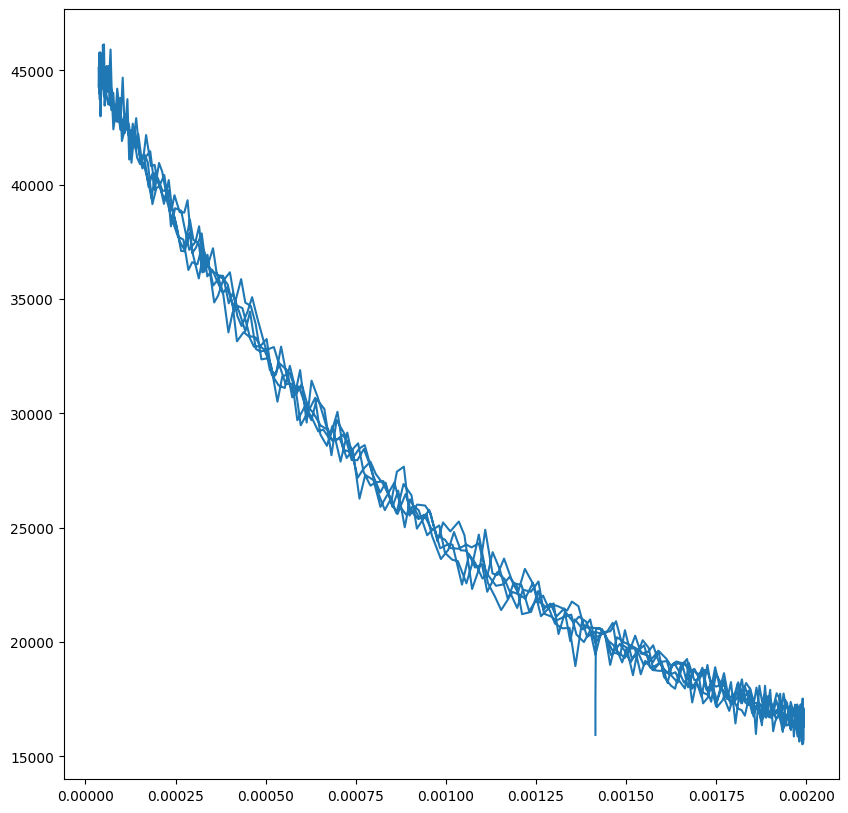

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
# plt.plot(time1, power, '-')
plt.plot(power1, counts, '-')
counts = np.array(counts)
# plt.plot(np.log10(max(power)-power), np.log10(counts-400), '-')
# plt.plot(np.log10(max(power)-power), 2*np.log10(max(power)-power)+11.3)

In [ ]:
max(power)

np.float64(0.002)

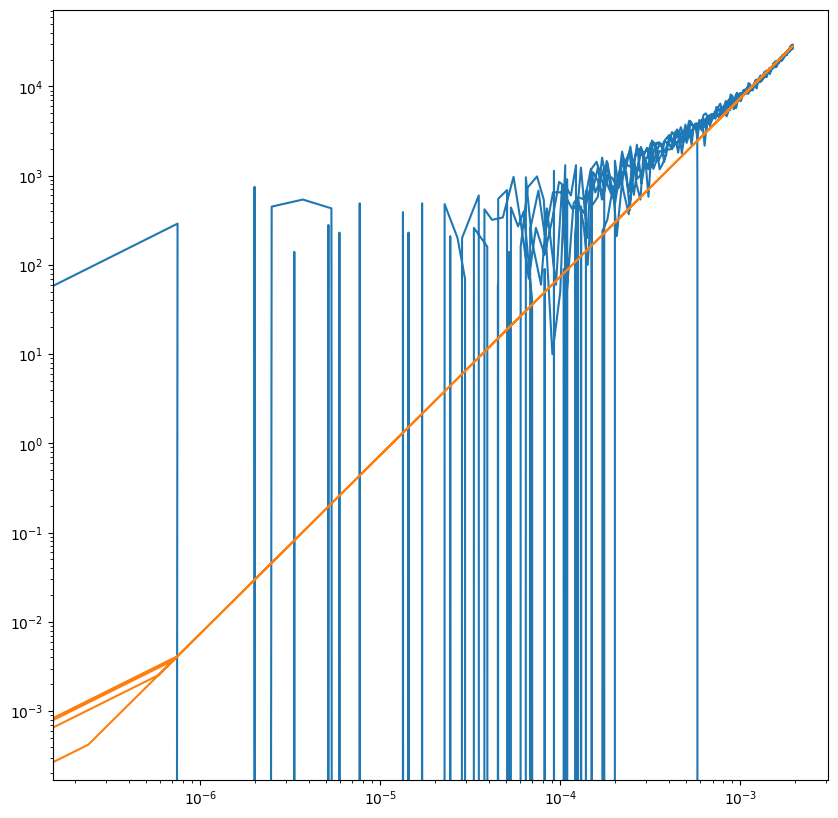

In [ ]:
counts = np.array(counts)

plt.figure(figsize=(10, 10), dpi=100)
# plt.plot(time1, power, '-')
plt.plot(max(power1)-power1, counts- min(counts)-1250, '-')

plt.plot(max(power1)-power1, max(counts- min(counts)-1250) * ((max(power1)-power1) / max(power1))**2, '-')

plt.yscale('log')
plt.xscale('log')
#plt.ylim([0, 1000])

In [ ]:
max(power)*1e6

np.float64(1991.9999999999998)

In [ ]:
Open_Shutter(serial_num)

shutter is opened


In [ ]:
Close_Shutter(serial_num)

shutter is closed


In [ ]:
rotator.move_by(15000)

In [ ]:
rotator.stop()

In [ ]:
rotator.get_position()

-39430057

In [ ]:
Close_Shutter(serial_num)

shutter is closed


Countrate0=11428530/s Countrate1=1190/s

Measuring for 50 milliseconds...
Countrate0=11428540/s Countrate1=1000/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1030/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1070/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1160/s

Measuring for 50 milliseconds...
Countrate0=11428540/s Countrate1=1090/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1090/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1240/s

Measuring for 50 milliseconds...
Countrate0=11428540/s Countrate1=1200/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1040/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1250/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1180/s

Measuring for 50 milliseconds...
Countrate0=11428540/s Countrate1=1050/s

Measuring for 50 milliseconds...
Countrate0=11428530/s Countrate1=1160/

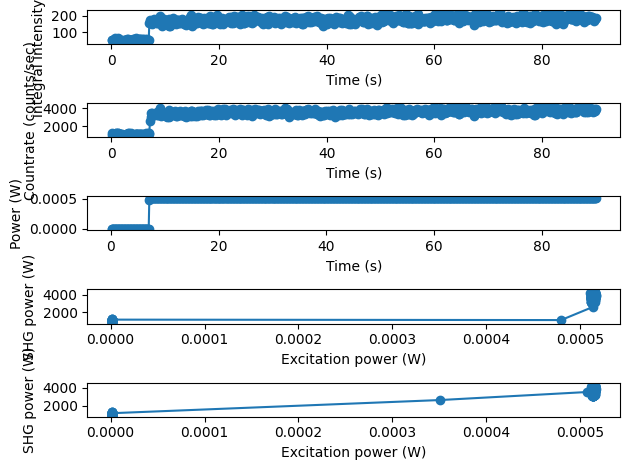

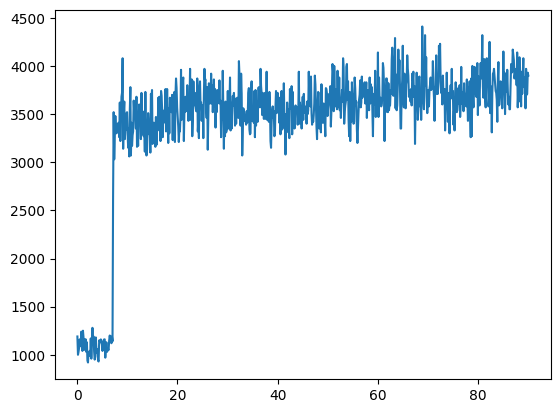

In [ ]:
power_modification = '_od2_power_meter_nothing_spad'
rotation_velocity = '0'
sample = ['Ga_As', 'Au_Si', 'TiO2_Au','Si_Au',]

current_time = datetime.datetime.now()
x = str(current_time.year) +'_'+ str(current_time.month)+'_'+ str(current_time.day) +'_'+ str(current_time.hour) +'_'+ str(current_time.minute)+'_'+ str(current_time.second)
i = sample[]+power_modification + 'rotation_velocity_' + rotation_velocity + '_'+  x

t_end = 90
t_acq = 50
Map, Times, counts, power, Times_power = Time_Dependent_Mes_no_rot(i, t_acq, t_end)


plt.plot(Times, counts, '-')

### No Rotator

In [ ]:
rotation_to_angle()

33.815797995462795 in Device Units: 64914
Countrate0=999990/s Countrate1=460/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=480/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=470/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=600/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=570/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=510/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=450/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=390/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=540/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=590/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=610/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=510/s

Measuring for 50 milliseconds...
Countrate0=999990/s Countrate1=550/s

Measuring for 50 milliseconds...
Countrate0=1000000/s Countrate1=

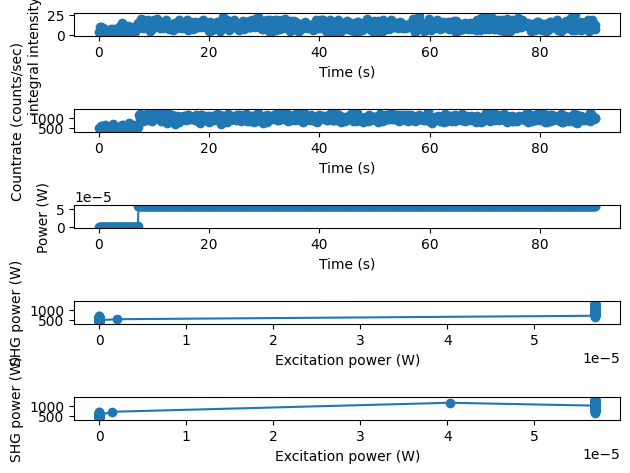

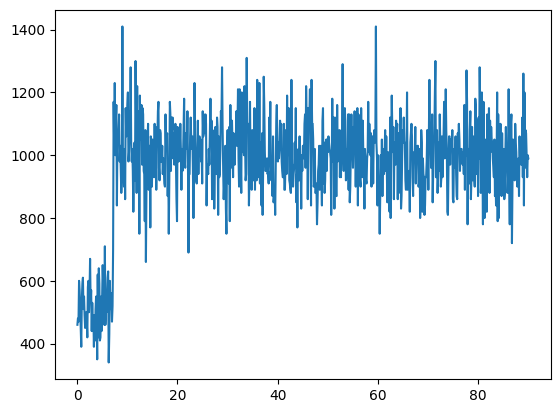

In [ ]:
for k in range(1):
    angle_in_degrees = power_angle(-A,B,C,D,0.0008)
    rotation_to_angle(serial_num,angle_in_degrees)
    time.sleep(10)
    power_modification = '_fixed_issues_od2_power_meter_nothing_spad'
    rotation_velocity = '0'
    sample = ['Ga_As', 'Au_Si', 'TiO2_Au','Si_Au',]

    current_time = datetime.datetime.now()
    x = str(current_time.year) +'_'+ str(current_time.month)+'_'+ str(current_time.day) +'_'+ str(current_time.hour) +'_'+ str(current_time.minute)+'_'+ str(current_time.second)
    i = sample[1]+power_modification + 'rotation_velocity_' + rotation_velocity +  x

    t_end = 90
    t_acq = 50
    Map, Times, counts, power, Times_power = Time_Dependent_Mes_no_rot(i, t_acq, t_end)

    time.sleep(90)
    plt.plot(Times, counts, '-')

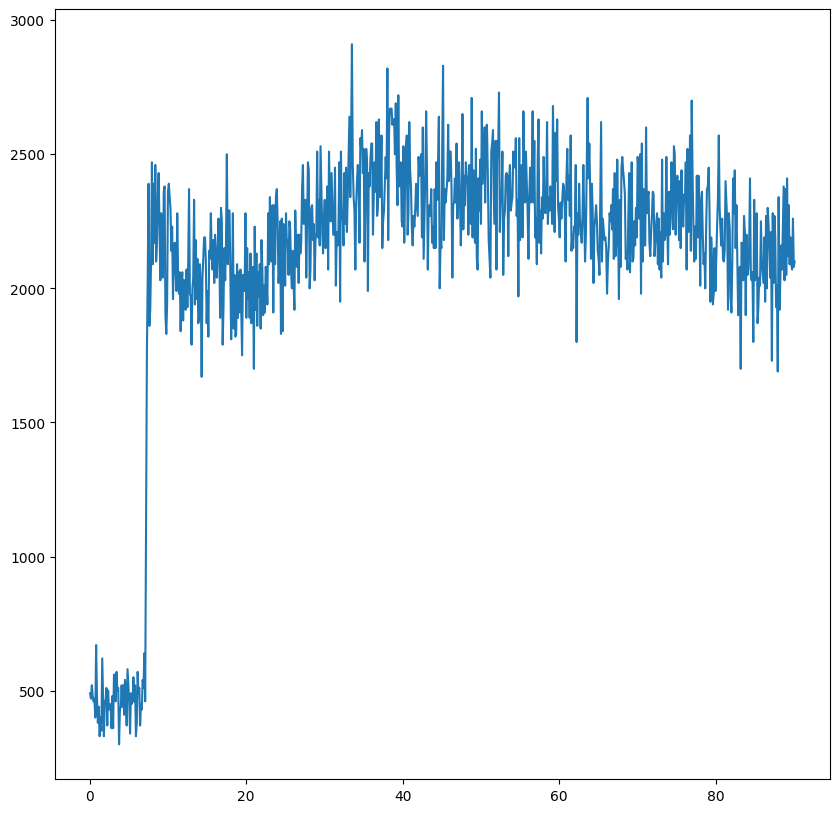

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
# plt.plot(time1, power, '-')
# plt.plot(time1, power1, '-')
plt.plot(Times, counts, '-')

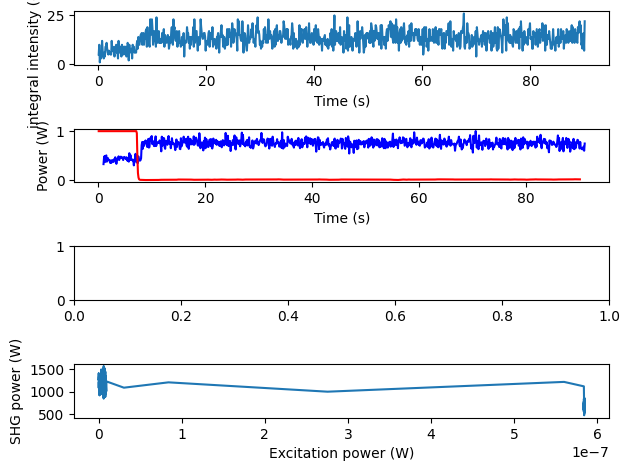

In [ ]:

power = np.array(power)
counts = np.array(counts)

fig, axs = plt.subplots(4)
ax = axs[0]
ax.plot(Times,Map, '-')
ax.set_xlabel('Time (s)')
ax.set_ylabel('integral intensity (counts)')

ax = axs[1]
ax.plot(np.array(Times) + 0.9,counts / max(counts), '-b')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Countrate (counts/sec)')

ax.plot(Times,(max(power)-power) / max(max(power)-power), '-r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Power (W)')

ax = axs[3]
ax.plot(max(power[:len(power)-1])-power[:len(power[:len(power) - 1])], counts[1:], '-')
ax.set_xlabel('Excitation power (W)')
ax.set_ylabel('SHG power (W)')

plt.tight_layout()

In [ ]:
(np.mean(np.array(Times_power) - np.array(Times)))

0.0371818834596926

Text(0, 0.5, 'SHG power (W)')

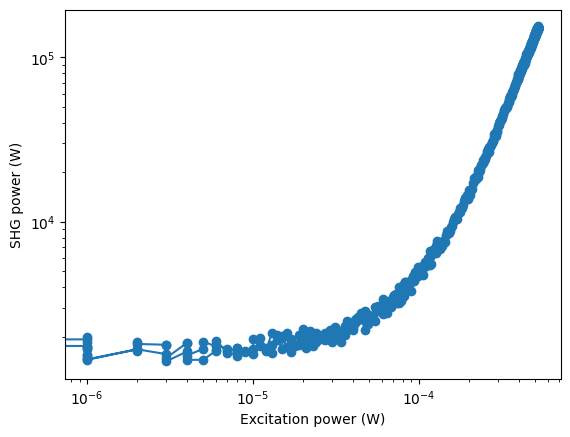

In [ ]:
power = np.array(power)
plt.loglog(max(power)-power, counts, '-o')
plt.xlabel('Excitation power (W)')
plt.ylabel('SHG power (W)')

Text(0, 0.5, 'SHG power (W)')

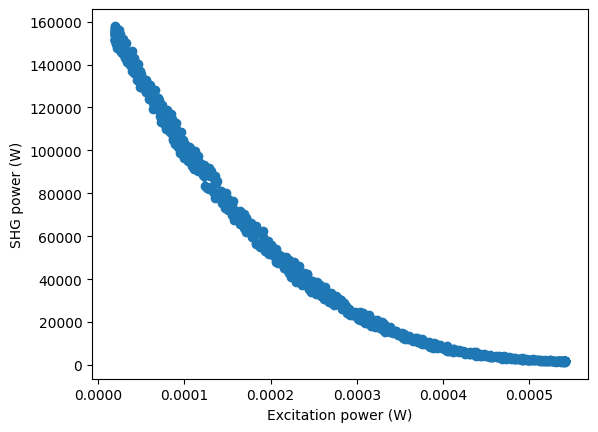

In [ ]:
power = np.array(power)
plt.plot(power, counts, '-o')
plt.xlabel('Excitation power (W)')
plt.ylabel('SHG power (W)')

Text(0, 0.5, 'SHG power (W)')

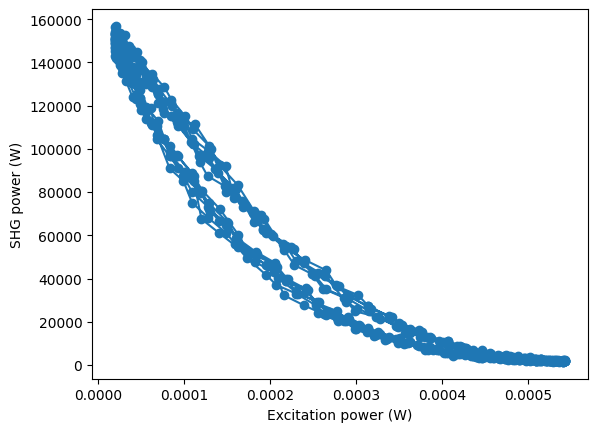

In [ ]:
power = np.array(power)
plt.plot(power, counts, '-o')
plt.xlabel('Excitation power (W)')
plt.ylabel('SHG power (W)')

In [ ]:
with open('10mW_TiO2_Time_Dependent'+str(t_acq) + 'ms' + str(1) + str(60) + 's' + '.txt', 'w') as file:
    for i in range(len(Times)):
                line = f"Intensity: {Map[i]:.1f}, Countrate: {counts[i]:.1f}, Power: {power[i]}, Time: {Times[i]}\n"
                file.write(line)
                i+=1

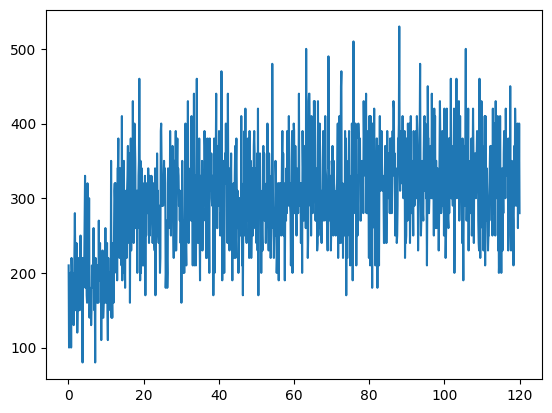

In [ ]:
power = np.array(power)
plt.plot(Times, counts)

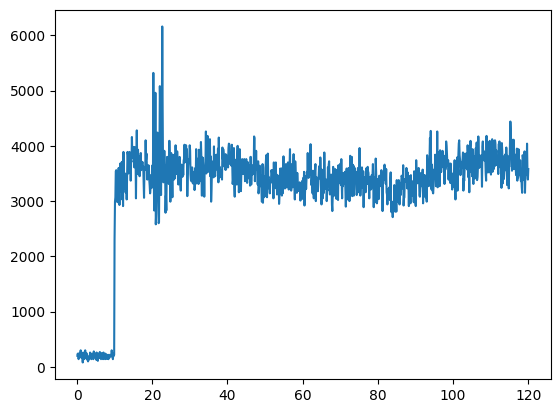

In [ ]:
power = np.array(power)
plt.plot(Times, counts)

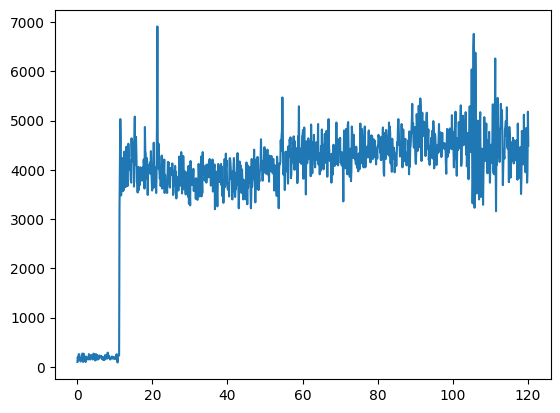

In [ ]:
power = np.array(power)
plt.plot(Times, counts)

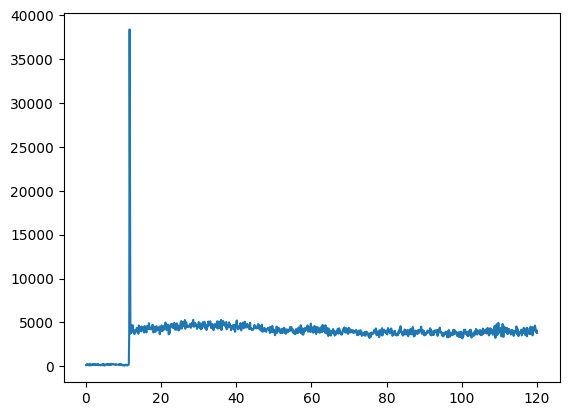

In [ ]:
power = np.array(power)
plt.plot(Times, counts)

In [ ]:
needed_powers = np.linspace(0.01, 0.1, 10)

In [ ]:
x_movement = 10
y_movement = 10
iter_x = 10
iter_y = 10

In [ ]:
angle = np.linspace(0,180,10)

In [ ]:
power = np.sin(angle*180/np.pi)

In [ ]:
print(power)

[ 0.          0.6930622  -0.99922629  0.74757789 -0.07859831 -0.63425834
  0.99304382 -0.79746812  0.15671031  0.57153017]


In [ ]:
Pjesa.pesa1.move(20)
Pjesa.pesa2.move(20)

In [ ]:
Map = LineAfterLineMes(Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angle, tacq)

20 20
1
[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
Countrate0=2499990/s Countrate1=140/s

Measuring for 100 milliseconds...
Countrate0=2500000/s Countrate1=290/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=120/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=60/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=80/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=170/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=190/s

Measuring for 100 milliseconds...
Countrate0=2500000/s Countrate1=120/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=100/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=190/s

Measuring for 100 milliseconds...
Countrate0=2500000

In [ ]:
Map2 = LineAfterLineMeswithPower(Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angle, tacq)

[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
-16.660994503081334 in Device Units: -31983
Countrate0=2500000/s Countrate1=140/s

Measuring for 100 milliseconds...
-17.46296763919274 in Device Units: -33523
Countrate0=2499990/s Countrate1=160/s

Measuring for 100 milliseconds...
-18.25767543240404 in Device Units: -35048
Countrate0=2500000/s Countrate1=120/s

Measuring for 100 milliseconds...
-19.04761344906591 in Device Units: -36565
Countrate0=2499990/s Countrate1=100/s

Measuring for 100 milliseconds...
-19.835147156666228 in Device Units: -38076
Countrate0=2499990/s Countrate1=140/s

Measuring for 100 milliseconds...
-20.622578025914244 in Device Units: -39588
Countrate0=2500000/s Countrate1=90/s

Measuring for 100 milliseconds...
-21.412204813606948 in Device Units: -41104
Countrate0=2

In [ ]:
x_c, y_c = 20, 20

In [ ]:
power = 0 

In [ ]:
def MapToFile(Map, filename):
        x = np.linspace(x_c - x_movement, x_c + x_movement, iter_x)
        y = np.linspace(y_c - y_movement, y_c + y_movement, iter_y)
        with open(filename, 'w') as file:
            for i in range(Map.shape[0]):
                for j in range (Map.shape[1]):
                
                    line = f"Coordinates: {x[i]:.3f}, {y[j]:.3f}, Intensity: {Map[i][j]:.5f}, Power: {power:.5f}\n"
                    file.write(line)
    


In [ ]:
MapToFile(Map,'КартаВолшебная')

In [ ]:
def MapToFileWithPowerMes(Map, filename, power1):
        x = np.linspace(x_c - x_movement, x_c + x_movement, iter_x)
        y = np.linspace(y_c - y_movement, y_c + y_movement, iter_y)
        with open(filename, 'w') as file:
            for i in range(Map.shape[0]):
                for j in range (Map.shape[1]):
                    for k in range (power1.shape[0]):
                
                        line = f"Coordinates: {x[i]:.3f}, {y[j]:.3f}, Intensity: {Map[i][j][k]:.5f}, Power: {power1[k]:.5f}\n"
                        file.write(line)
    

In [ ]:
MapToFileWithPowerMes(Map2, 'КартаМощная', needed_powers)

In [ ]:
Map = LineAfterLineMesToFile('КартаВременная',Picoharp,Pjesa, x_movement,y_movement,iter_x, iter_y,needed_powers, power, angle, tacq)

20 20
1
[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
[10.         12.22222222 14.44444444 16.66666667 18.88888889 21.11111111
 23.33333333 25.55555556 27.77777778 30.        ]
Countrate0=2499990/s Countrate1=200/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=170/s

Measuring for 100 milliseconds...
Countrate0=2500000/s Countrate1=150/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=110/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=140/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=240/s

Measuring for 100 milliseconds...
Countrate0=2500000/s Countrate1=180/s

Measuring for 100 milliseconds...
Countrate0=2500000/s Countrate1=140/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=120/s

Measuring for 100 milliseconds...
Countrate0=2499990/s Countrate1=130/s

Measuring for 100 milliseconds...
Countrate0=24999